In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
plt.style.use('dark_background')

In [2]:
import scipy.stats
from sklearn.metrics import mean_squared_error

plots_dir = Path.cwd() / "../plots"


## Evaluation of classification


In [25]:
INCLUDE_NOT_DETECTED_IN_SCORE = False

results_dir_detection = Path.cwd() / "../results/detection_per_mol/"

filenames_detection = {
    "all_feat": "detection_results_all_feat.csv",
    "fingerprints_feat": "detection_results_fingerprints_feat.csv",
    "mol_feat": "detection_results_mol_feat.csv",
    "random_feat": "detection_results_random_feat.csv",
    "no_feat": "detection_results_no_features.csv",
}



In [26]:
results_dir_regression = Path.cwd() / "../results/regression_on_detected"

filenames_regression = {
    "all_feat": "regr_results_all_feat.csv",
    "fingerprints_feat": "regr_results_fingerprints_feat.csv",
    "mol_feat": "regr_results_mol_feat.csv",
    "random_feat": "regr_results_random_feat.csv",
    "no_feat": "regr_results_no_feat.csv",
}


### Get detection predictions
And add random-guess baseline

In [67]:
# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
detection_models_results = pd.DataFrame()

for training_setup in filenames_detection:
    result_filename = filenames_detection[training_setup]
    loc_models_results = pd.read_csv(results_dir_detection / result_filename, index_col = 0)

    # -----------------------------------------
    # Add extra baseline randomly guessing:
    # -----------------------------------------

    baseline_results = loc_models_results.drop(columns=["classifier", "prediction", "fold"]).drop_duplicates().reset_index(drop=True)
    baseline_results["prediction"] = 0
    baseline_results["fold"] = 0
    baseline_results["classifier"] = "random_guess"

    for (matrix, polarity), rows in baseline_results.groupby(['matrix', 'polarity']):
        detected_prob = float(rows["observed_value"].sum()) / len(rows)
        prediction = (np.random.random(size=len(rows)) < detected_prob).astype('int')
        baseline_results.loc[rows.index.to_list(), "prediction"] = prediction

    loc_models_results = pd.concat([loc_models_results, baseline_results])

    # FIXME: remove broken results GaussianProcess
    loc_models_results = loc_models_results[loc_models_results.classifier != "GaussianProcess"]

    loc_models_results["train_setup"] = training_setup
    detection_models_results = pd.concat([detection_models_results, loc_models_results])




In [68]:
detection_models_results.classifier.value_counts()

Logistic_reg    16900
SVC_rbf         16900
SVC_poly        16900
KNeighbors      16900
DecisionTree    16900
RandomForest    16900
MLP             16900
random_guess    16900
Name: classifier, dtype: int64

### Get regression predictions
And add random-guess baseline

In [69]:
regr_models_results = pd.DataFrame()

for train_setup in filenames_regression:
    result_filename = filenames_regression[train_setup]
    loc_models_results = pd.read_csv(results_dir_regression / result_filename, index_col = 0)
    loc_models_results = loc_models_results.rename(columns={'Matrix short': 'matrix',
                                                          'Polarity': 'polarity'})

    # -----------------------------------------
    # Add extra baseline randomly guessing:
    # -----------------------------------------

    baseline_results = loc_models_results.drop(columns=["regressor", "prediction", "fold"]).drop_duplicates().reset_index(drop=True)
    baseline_results["prediction"] = 0
    baseline_results["fold"] = 0
    baseline_results["regressor"] = "random_guess"

    for (matrix, polarity), rows in baseline_results.groupby(['matrix', 'polarity']):
        detected_prob = float((rows["observed_value"] > 0).sum()) / len(rows)
        prediction = (np.random.random(size=len(rows)) < detected_prob).astype('int') * 2.
        baseline_results.loc[rows.index.to_list(), "prediction"] = prediction

    loc_models_results = pd.concat([loc_models_results, baseline_results])

    # FIXME: remove broken results GaussianProcess
    loc_models_results = loc_models_results[loc_models_results.regressor != "GaussianProcess"]

    loc_models_results["train_setup"] = train_setup
    regr_models_results = pd.concat([regr_models_results, loc_models_results])



Merge results:


In [70]:
detection_models_results = detection_models_results.rename(columns={"classifier": "model_type"}).drop(columns=["fold", "observed_value"])
regr_models_results = regr_models_results.rename(columns={"regressor": "model_type", "prediction": "regr_prediction"}).drop(columns=["fold"])


In [55]:
# merged_results = detection_models_results.merge(regr_models_results, how="right", on=["model_type", 'name_short', 'matrix', 'polarity', 'train_setup'])
# merged_results["detection_prediction"] = merged_results["prediction"]
# merged_results["prediction"] = np.where(merged_results["detection_prediction"] > 0, merged_results["regr_prediction"], 0)


In [73]:
regr_models_results = regr_models_results.sort_values(by=["model_type", 'name_short', 'matrix', 'polarity', 'train_setup', 'adduct']).reset_index(drop=True)
detection_models_results = detection_models_results.sort_values(by=["model_type", 'name_short', 'matrix', 'polarity', 'train_setup']).reset_index(drop=True)
det_pred_column = detection_models_results.loc[detection_models_results.index.repeat(7), "prediction"].reset_index(drop=True)
regr_models_results["detection_prediction"] = det_pred_column
regr_models_results["prediction"] = np.where(regr_models_results["detection_prediction"] > 0, regr_models_results["regr_prediction"], 0)

### Compute scores

In [79]:

metric = "Spearman's R"

# compute Spearman's/Pearson's correlation and mean squared error for each matrix/polarity/regressor
scores = ["Spearman's R", 'S pval', "Pearson's R", 'P pval', 'RMSE', 'RMSE/std', 'non-zero obs']
model_metrics = pd.DataFrame(columns = ['train_setup', 'matrix', 'polarity', 'model_type'] + scores)
model_metrics_global = pd.DataFrame(columns = ['train_setup', 'model_type'] + scores)
counter = 0
counter_global = 0

for (matrix, polarity, model_type, train_setup), rows in regr_models_results.groupby(['matrix', 'polarity', 'model_type', 'train_setup']):
    # remove zero intensity molecules if needed (optional)
    if not INCLUDE_NOT_DETECTED_IN_SCORE:
        rows = rows[rows['observed_value']!=0]

    spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
    pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
    mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
    mse_std = mse / rows['observed_value'].std()
    model_metrics.loc[counter] = [train_setup, matrix, polarity, model_type, spearman[0], spearman[1],
                                       pearson[0], pearson[1], mse, mse_std,
                                       rows[rows['observed_value']!=0].shape[0]]
    counter += 1

# Compute global scores:
for (model_type, train_setup), rows in regr_models_results.groupby(['model_type', 'train_setup']):
    # remove zero intensity molecules if needed (optional)
    if not INCLUDE_NOT_DETECTED_IN_SCORE:
        rows = rows[rows['observed_value']!=0]

    spearman = scipy.stats.spearmanr(rows.observed_value, rows.prediction)
    pearson = scipy.stats.pearsonr(rows.observed_value, rows.prediction)
    mse = mean_squared_error(rows.observed_value, rows.prediction, squared = False)
    mse_std = mse / rows['observed_value'].std()
    model_metrics_global.loc[counter_global] = [train_setup, model_type, spearman[0], spearman[1],
                                       pearson[0], pearson[1], mse, mse_std,
                                       rows[rows['observed_value']!=0].shape[0]]
    counter_global += 1


/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4529: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/Users/alberto-mac/miniforge3/envs/pyTorch/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInpu

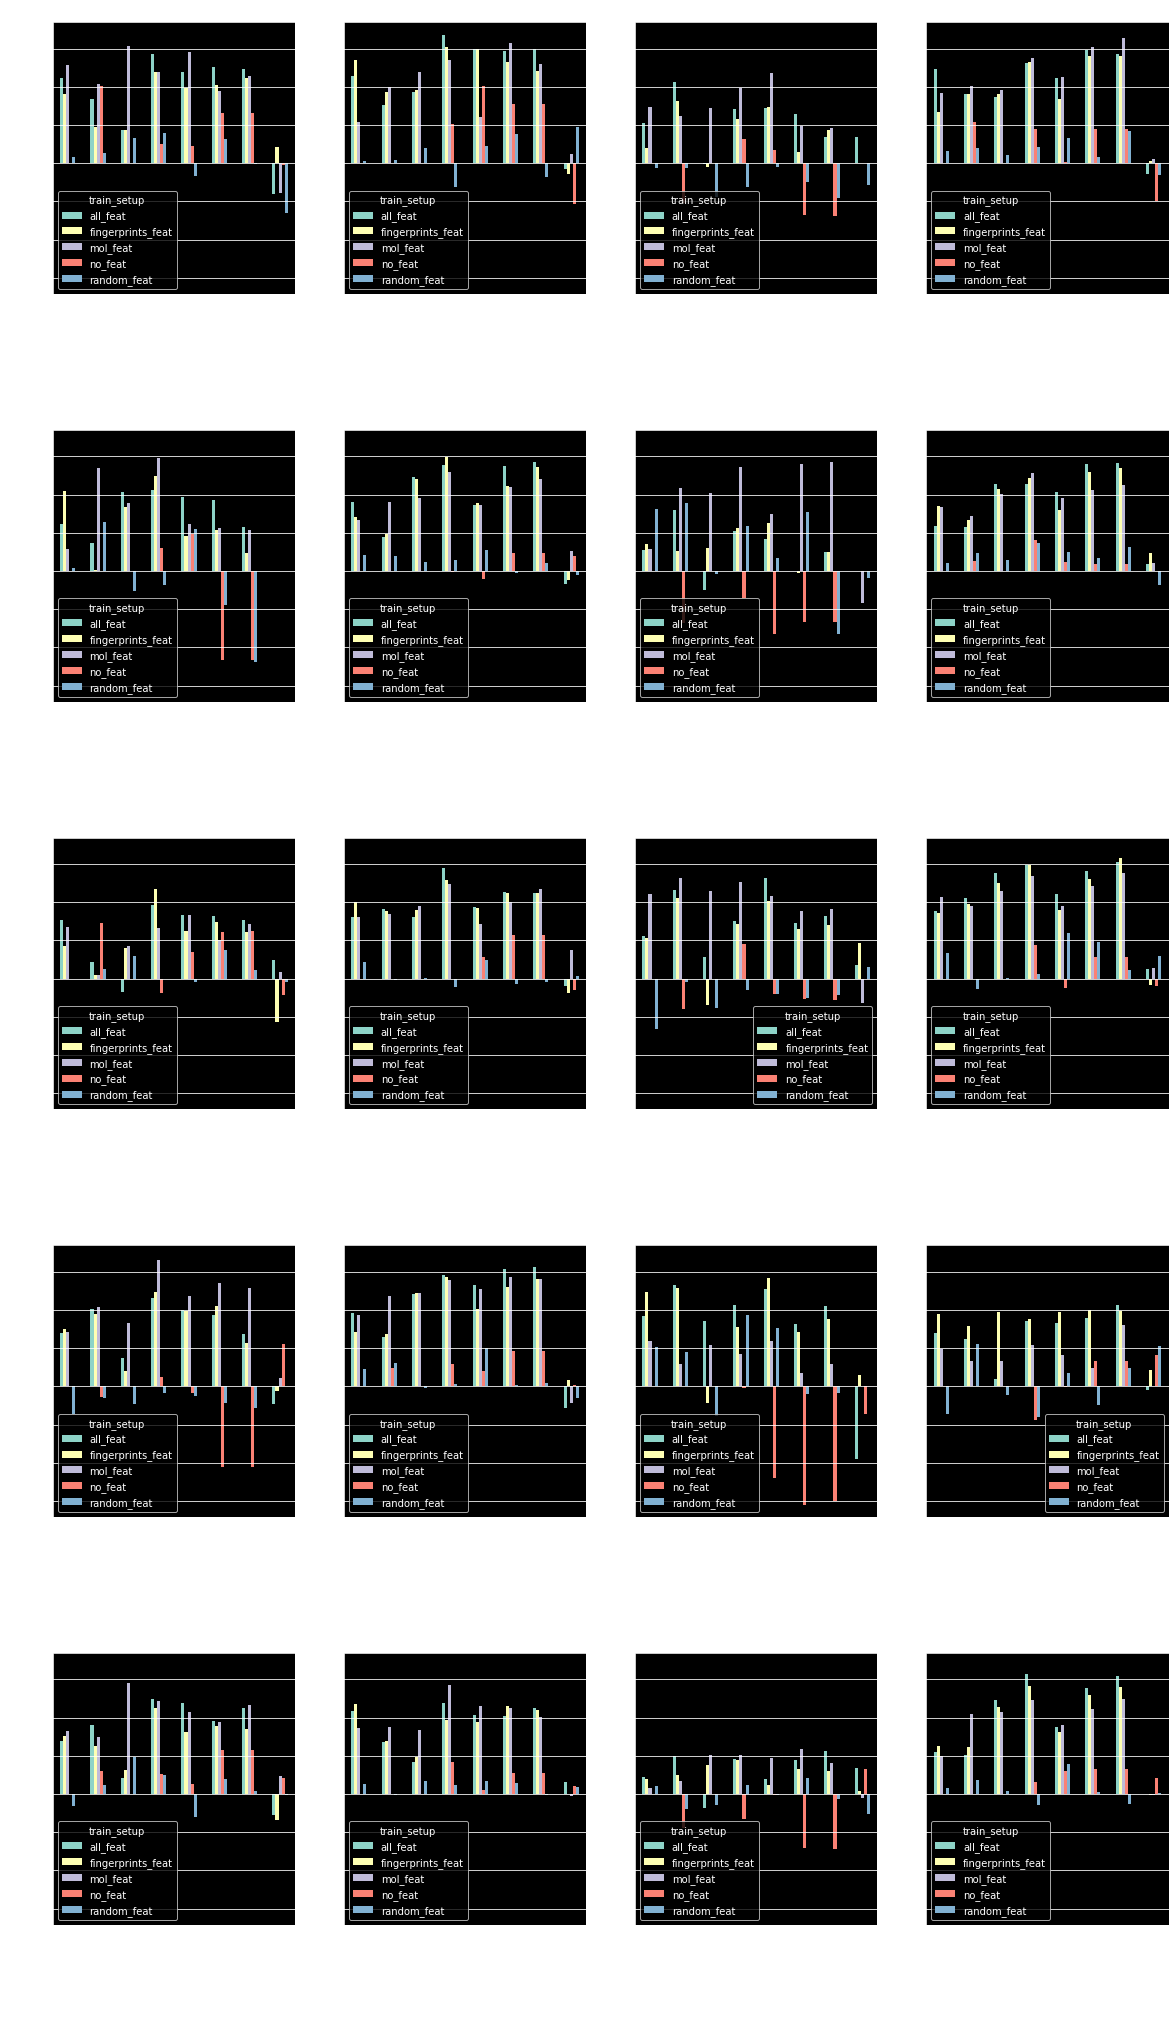

In [80]:
fig, axes = plt.subplots(ncols=4,nrows=5, sharey=True, figsize= (20, 35))
ax_list = axes.flat

metric = "Spearman's R"
#metric = "RMSE"

i = 0
for (matrix, polarity), rows in model_metrics.groupby(['matrix', 'polarity']):
    nb_obs = rows['non-zero obs'].drop_duplicates().values[0]
    rows = rows.set_index(['model_type', "train_setup"], drop = True).sort_values( by = ["train_setup", metric])
    rows = rows.unstack("train_setup")
    rows[metric].plot.bar(ax = ax_list[i], title=f"{matrix}-{polarity} ({nb_obs})")
    ax_list[i].set_ylabel(metric)
    ax_list[i].grid(axis='y')
    # if i != 0:
    #     ax_list[i].get_legend().set_visible(False)
    i+=1

plt.subplots_adjust(hspace=0.5)
plt.show()


For each matrix, get the max "Spearman's R" achieved, and compute difference between this max value and
 the value achieved by each model (compare bars of same colors, not across colors). MLP seems to be the best in all setups:

<AxesSubplot:xlabel='model_type'>

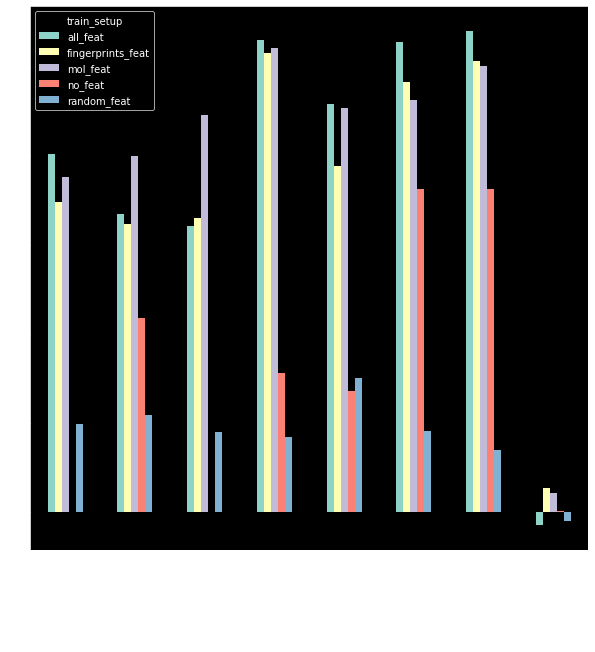

In [81]:
model_metrics_global.set_index(["model_type", "train_setup"], drop=True)[metric].unstack("train_setup").plot.bar(figsize=(10,10))